In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("course_lead_scoring.csv")
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [34]:
categorical_features = ["lead_source", "industry", "employment_status", "location"]
numerical_features = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]

In [35]:
for feature in categorical_features:
    df[feature] = df[feature].fillna("NA")

for feature in numerical_features:
    df[feature] = df[feature].fillna(0.0)

In [37]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Check proportions
print("Train size:", len(df_train), len(y_train))
print("Validation size:", len(df_val), len(y_val))
print("Test size:", len(df_test), len(y_test))

Train size: 876 876
Validation size: 293 293
Test size: 293 293


# Question 1: ROC AUC feature importance

In [39]:
from sklearn.metrics import roc_auc_score

for f in numerical_features:
    # Compute raw AUC
    auc = roc_auc_score(y_train, df_train[f])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[f])
    print(f"Feature: {f} \nauc: {round(auc,3)}")

Feature: number_of_courses_viewed 
auc: 0.764
Feature: annual_income 
auc: 0.552
Feature: interaction_count 
auc: 0.738
Feature: lead_score 
auc: 0.614


# Question 2: Training the model

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [41]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Make predictions on validation set
y_pred = model.predict_proba(X_val)[:, 1]

In [42]:
# AUC of this model on the validation dataset
round(roc_auc_score(y_val, y_pred),3)

0.817

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145
0.345
0.545
0.745

In [43]:
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0.0, 1.0, 101)
scores = []

# For each threshold, compute precision and recall
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum() # True positive
    tn = (predict_negative & actual_negative).sum() # True negative

    fp = (predict_positive & actual_negative).sum() # False positive
    fn = (predict_negative & actual_positive).sum() # False negative
    
    scores.append((t, tp, fp, fn, tn))

In [44]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [45]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,122,0,0,0.583618,1.000000
2,0.02,171,122,0,0,0.583618,1.000000
3,0.03,171,122,0,0,0.583618,1.000000
4,0.04,171,122,0,0,0.583618,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544
97,0.97,1,0,170,122,1.000000,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000


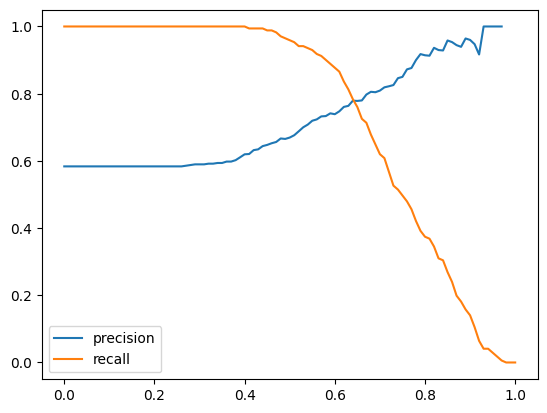

In [46]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

# Question 4: F1 score

In [47]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

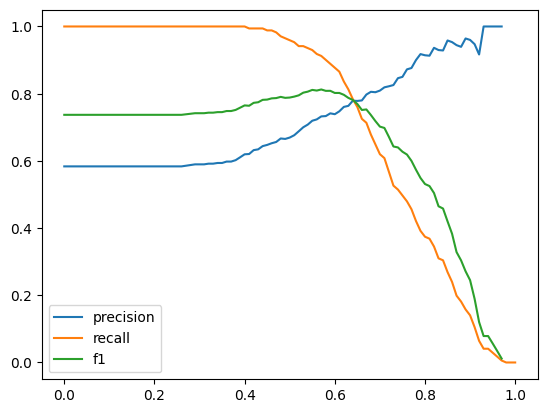

In [48]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()

# Question 5: 5-Fold CV

In [18]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
fold = 0


for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    # Initialize the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    
    # Fit the model on training data
    model.fit(X_train, y_train)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # Make predictions on validation set
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    print(f'auc on fold {fold}: {auc}')
    fold = fold + 1

auc on fold 0: 0.8688304920717635
auc on fold 1: 0.9216514191883649
auc on fold 2: 0.8433810305731487
auc on fold 3: 0.8422322540473225
auc on fold 4: 0.9026466491255224


In [19]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.876 +- 0.032


# Question 6

In [29]:
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    score = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train['converted'].values
        y_val = df_val['converted'].values
    
        dv = DictVectorizer(sparse=False)
        
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
    
        # Initialize the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        
        # Fit the model on training data
        model.fit(X_train, y_train)
    
        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)
    
        # Make predictions on validation set
        y_pred = model.predict_proba(X_val)[:, 1]
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f"C={C}, mean={round(np.mean(scores),3)}, std={round(np.std(scores),3)}")

C=1e-06, mean=0.777, std=0.165
C=0.001, mean=0.785, std=0.164
C=1, mean=0.79, std=0.162
